In [1]:
# Training variables
rolling_mean = 90

## Import data from AWS S3

In [2]:
import sys
sys.path.insert(0, '/home/khiem/Dropbox/Education/Drexel/DSCI-591/Project/Walmart-Strategic-Sales-Forecasting')

In [3]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_1_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [4]:
from data_processing.pre_modeling import pre_modeling

df_processed = pre_modeling(df)

## Data Analysis

In [5]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col] # extract the remaining columns

In [6]:
df_used = df_processed[timeseries_cols+target_col]
df_used = df_used.rolling(rolling_mean).mean().dropna()

In [7]:
nobs = 30
df_original = df_used
df_test = df_used[-nobs:]
df_train = df_used[0:-nobs]

print(df_train.columns)

Index(['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies',
       'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price',
       'store_sales'],
      dtype='object')


In [8]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value > sig:
        return True
    else:
        return False

def adfuller_test_all(df, sig=0.05):
    non_stationary = []
    stationary = []
    for name, column in df_train.iteritems():
        if adfuller_test(column, name=column.name):
            non_stationary.append(column.name)
        else:
            stationary.append(column.name)

    print('Non-stationary:', non_stationary)
    print('Stationary:', stationary)

adfuller_test_all(df_train)

Non-stationary: ['cpi', 'unemployment_rate', 'gas_price', 'median_price', 'max_price', 'store_sales']
Stationary: ['ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'min_price']


In [9]:
df_train = df_train.diff().dropna()
adfuller_test_all(df_train)

Non-stationary: []
Stationary: ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price', 'store_sales']


In [10]:
from statsmodels.tsa.api import VAR

df_train_fit = df_train[timeseries_cols+target_col]
model = VAR(df_train_fit)
x = model.select_order(maxlags=12)
x.summary()

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-84.55,-84.52,1.906e-37,-84.54
1,-108.2,-107.8*,1.060e-47,-108.0
2,-108.5,-107.7,7.562e-48,-108.2
3,-108.6,-107.4,6.969e-48,-108.2
4,-108.7,-107.2,6.394e-48,-108.1
5,-108.7,-106.8,6.088e-48,-108.0
6,-109.0,-106.7,4.780e-48,-108.1
7,-109.3,-106.6,3.552e-48,-108.3
8,-109.9*,-107.0,1.800e-48*,-108.8*
9,-109.9,-106.6,1.866e-48,-108.7


In [11]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Jul, 2022
Time:                     04:22:34
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -106.624
Nobs:                     1814.00    HQIC:                  -108.266
Log likelihood:           71613.1    FPE:                3.66202e-48
AIC:                     -109.227    Det(Omega_mle):     2.30461e-48
--------------------------------------------------------------------
Results for equation cpi
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000345         0.000086            4.010           0.000
L1.cpi                       0.934161         0.024966           37.418           0.000
L1.unemployment_rate         0.026

In [12]:
print(model_fitted.params["store_sales"][["const", 
                                          "L1.ca_walmart", "L1.ca_household", "L1.ca_foods", "L1.max_price", "L1.store_sales", 
                                          "L2.gas_price", "L2.ca_walmart", "L2.ca_foods", "L2.store_sales", 
                                          "L3.cpi", "L3.ca_walmart", 
                                          "L5.ca_walmart", "L5.min_price", "L5.store_sales", 
                                          "L6.ca_walmart", "L6.store_sales", "L7.ca_walmart", "L7.ca_hobbies", "L7.ca_foods", "L7.store_sales"]])

const                 1.259525
L1.ca_walmart         5.090656
L1.ca_household       3.176563
L1.ca_foods          -4.118235
L1.max_price        175.980093
L1.store_sales        0.267396
L2.gas_price       1455.428051
L2.ca_walmart       -13.882661
L2.ca_foods           8.402681
L2.store_sales       -0.118455
L3.cpi             -300.661929
L3.ca_walmart         7.448682
L5.ca_walmart        -7.312612
L5.min_price      -6356.082071
L5.store_sales       -0.095153
L6.ca_walmart        11.059794
L6.store_sales        0.126778
L7.ca_walmart        10.704880
L7.ca_hobbies         3.354800
L7.ca_foods          -9.163245
L7.store_sales        0.448157
Name: store_sales, dtype: float64


In [13]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_train_fit.values[-lag_order:]
forecast_input

7


array([[ 1.48888889e-02,  3.33333333e-03,  7.66666667e-04,
         5.26666667e-02,  4.35555556e-02,  2.37000000e-01,
         1.74000000e-01, -4.44089210e-16,  3.33333333e-04,
         1.11111111e-04,  1.66666667e-01],
       [ 1.48888889e-02,  3.33333333e-03,  1.67777778e-03,
         1.22666667e-01, -7.24444444e-02,  5.56666667e-02,
         1.54666667e-01,  0.00000000e+00,  3.33333333e-04,
         1.11111111e-04,  1.63333333e+01],
       [ 1.48888889e-02,  3.33333333e-03,  2.42222222e-03,
         6.63333333e-02,  1.86666667e-02,  1.15222222e-01,
         2.51111111e-01,  4.44089210e-16,  3.33333333e-04,
         1.11111111e-04,  1.46555556e+01],
       [ 1.48888889e-02,  3.33333333e-03,  2.42222222e-03,
         8.36666667e-02, -8.88888889e-03, -1.70000000e-01,
         2.50000000e-01, -4.44089210e-16,  3.33333333e-04,
         1.11111111e-04,  2.76666667e+00],
       [ 1.48888889e-02,  3.33333333e-03,  2.42222222e-03,
         8.70000000e-02,  4.04444444e-02, -7.75555556e-02,
  

In [14]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_train_fit.columns + '_1d')
df_forecast["store_sales_1d"]

2016-04-23    -4.212290
2016-04-24    11.041227
2016-04-25     9.789249
2016-04-26     3.111868
2016-04-27     3.147826
2016-04-28    -1.570156
2016-04-29   -11.002644
2016-04-30    -3.337259
2016-05-01     8.789347
2016-05-02     8.173920
2016-05-03     3.884463
2016-05-04     3.197850
2016-05-05    -1.617654
2016-05-06    -8.383565
2016-05-07    -2.926095
2016-05-08     6.599814
2016-05-09     7.102413
2016-05-10     4.141472
2016-05-11     3.016044
2016-05-12    -1.434856
2016-05-13    -6.529155
2016-05-14    -2.558910
2016-05-15     4.936911
2016-05-16     6.097218
2016-05-17     4.115794
2016-05-18     2.766616
2016-05-19    -1.188059
2016-05-20    -5.152945
2016-05-21    -2.235052
2016-05-22     3.679921
Name: store_sales_1d, dtype: float64

In [15]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs][timeseries_cols+target_col], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,median_price_1d,min_price_1d,max_price_1d,...,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,median_price_forecast,min_price_forecast,max_price_forecast,store_sales_forecast
2016-04-23,0.015494,0.003076,0.002368,0.066857,0.013146,0.027994,0.172479,0.000003,0.000305,0.000077,...,4.977521,2.013302,24.976190,27.243257,39.448772,52.342590,3.480003,0.214305,29.970077,4420.321043
2016-04-24,0.015988,0.002891,0.002369,0.112814,0.053410,-0.041591,0.171086,0.000010,0.000288,0.000121,...,4.980411,2.015670,25.089004,27.296667,39.407180,52.513676,3.480013,0.214593,29.970198,4431.362270
2016-04-25,0.016484,0.002761,0.002372,0.092816,0.029216,-0.064830,0.167471,0.000002,0.000245,0.000803,...,4.983172,2.018042,25.181820,27.325883,39.342350,52.681147,3.480015,0.214838,29.971001,4441.151519
2016-04-26,0.016510,0.002659,0.002384,0.065622,0.018666,-0.039522,0.156373,0.000016,0.000221,0.001077,...,4.985831,2.020426,25.247443,27.344549,39.302828,52.837521,3.480031,0.215059,29.972078,4444.263387
2016-04-27,0.016701,0.002551,0.002402,0.074664,0.033698,-0.051285,0.166035,0.000022,0.000229,0.001390,...,4.988382,2.022829,25.322107,27.378247,39.251542,53.003555,3.480053,0.215288,29.973468,4447.411213
2016-04-28,0.016613,0.002470,0.002459,0.051944,0.029673,-0.043751,0.176072,0.000024,0.000199,0.001738,...,4.990852,2.025287,25.374051,27.407920,39.207791,53.179627,3.480078,0.215487,29.975206,4445.841057
2016-04-29,0.016949,0.002366,0.002450,0.000175,-0.004391,-0.005084,0.168622,0.000020,0.000189,0.001740,...,4.993218,2.027737,25.374225,27.403529,39.202707,53.348249,3.480097,0.215676,29.976946,4434.838413
2016-04-30,0.017135,0.002260,0.002484,0.020169,-0.001469,-0.032120,0.127765,0.000022,0.000165,0.002015,...,4.995478,2.030221,25.394395,27.402060,39.170588,53.476014,3.480120,0.215842,29.978961,4431.501153
2016-05-01,0.017407,0.002163,0.002505,0.068200,0.025539,-0.068191,0.119156,0.000028,0.000148,0.002347,...,4.997641,2.032726,25.462594,27.427598,39.102397,53.595170,3.480148,0.215990,29.981307,4440.290500
2016-05-02,0.017590,0.002075,0.002489,0.069899,0.023119,-0.070207,0.126344,0.000030,0.000141,0.002623,...,4.999716,2.035215,25.532493,27.450717,39.032190,53.721514,3.480178,0.216131,29.983931,4448.464421


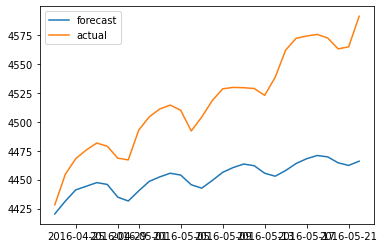

In [16]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


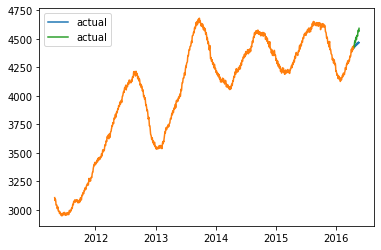

In [17]:
plt.plot(df_results["store_sales_forecast"].index, df_results["store_sales_forecast"], label = "actual")
plt.plot(df_original["store_sales"][0:-nobs].index, df_original["store_sales"][0:-nobs])
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()

In [18]:
# evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np

error_mse = mean_squared_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_rmse = np.sqrt(error_mse)
error_r2 = r2_score(df_test["store_sales"], df_results["store_sales_forecast"])
error_wape = ((df_results["store_sales_forecast"] - df_test["store_sales"]) / df_test["store_sales"]).mean() 
error_wmape = np.mean(np.abs(df_test["store_sales"] - df_results["store_sales_forecast"]) / df_test["store_sales"])
print("MSE:", error_mse)
print("RMSE:", error_rmse)
print("R2:", error_r2)
print("WAPE:", error_wape)
print("WMAPE:", error_wmape)


MSE: 5195.068095059397
RMSE: 72.07682078906781
R2: -2.0556738432414137
WAPE: -0.014449226228571385
WMAPE: 0.014449226228571385
